# Final Project - Detecting Fraudulent Credit Card Transactions

| Course | Term | Section | Group | Objective | Kaggle URL |
| --- | --- | --- | --- | --- | --- |
| W207 | Fall 2022 | 11 | 2 | Detect fraudulent credit card transactions | IEEE-CIS Fraud Detection ([Link](kaggle.com/competitions/ieee-fraud-detection)) |

### Group Members 
- Naikaj Pandya
- Chase Madson
- Eric Danforth


# I. Setup

## Import Packages

In [1]:
# Import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
from math import floor
# sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# import tensorflow as tf
# from tensorflow import keras
# from keras import metrics
# tf.get_logger().setLevel('INFO')

## Load Data

In [2]:
train_identity = pd.read_csv('data/train_identity.csv')
train_transaction = pd.read_csv('data/train_transaction.csv')
test_identity = pd.read_csv('data/test_identity.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')
sub = pd.read_csv('data/sample_submission.csv')
# let's combine the data and work with the whole dataset
#train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
#test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# II. EDA

## First Look at the Data

This data is collected by Vesta’s fraud protection system and digital security partners (the sponsors of this competition).

In [3]:
tmp_dict = {
 name:{
    'Transactions': len(df), 
    'Features': len(df.columns),
    'Features w/ Nulls': df.isnull().any().sum(),
    'Date Range': [floor(i / (60 * 60 * 24)) - 1 for i in (df['TransactionDT'].min(), df['TransactionDT'].max())] 
                  if 'TransactionDT' in df else '',
    'Percent Fraudulent': str(round(100 * df.isFraud.sum() / len(df), 3)) + '%'
                          if 'isFraud' in df else '',
    }
 for df, name
 in zip(
   (train_transaction, test_transaction, train_identity, test_identity),
   ('train_transaction', 'test_transaction', 'train_identity', 'test_identity')
   )
}

pd.DataFrame.from_dict(tmp_dict, dtype='str')

,train_transaction,test_transaction,train_identity,test_identity
Transactions,590540,506691,144233,141907
Features,394,393,41,41
Features w/ Nulls,374,345,38,38
Date Range,"[0, 181]","[212, 394]",,
Percent Fraudulent,3.499%,,,


### Takeaways
**Big Data**: We have over half a million records of card transactions in each of `train_transaction` and `test_transaction` datasets, and a maximum of 434 features to work with

- **Missing Data**: Almost all the columns include some portion of missing data, which may need to be addressed before our final model  

- **Masked Data**: Most feature names are intentionally masked for privacy protection and contract agreement

- **Imbalanced Outcome Variable**: Only 3.5% of transactions are marked fraud, so we may want to balance the training data before our final model - we should be cautious of accuracy as a metric

**Identity Tables as Subset of Transaction Tables**: The identity tables do not include our outcome variable but instead include network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions
- The transactions in `train_identity` are a subset of the transactions in `train_transaction`, as is `test_identity` to `test_transaction` 
- About 25% of the transactions in `training_transaction` have a corresponding record in `training_identity`
- Because joining `training_identity` features to `training_transaction` will introduce a lot of `NULL` values, we will simply create a binary variable `have_identity` to indicate whether a transaction appears in both tables

**Differing Transaction Date Ranges**: The transaction dates in `training_transaction` appear to cover a 181-day time period starting at day 0, while the transaction dates in `test_transaction` appear to cover a 182-day time period starting at day 212  
- The training and test data do not overlap in time
- Though the data publishers deliberately mask the dates of this data, we infer that Day 0 is June 1, 2018 based on timing of the competition the apparent choice to omit December as an outlier holiday month 


## Transaction Amount

(-0.5, 1.5, 0.0, 400.0)

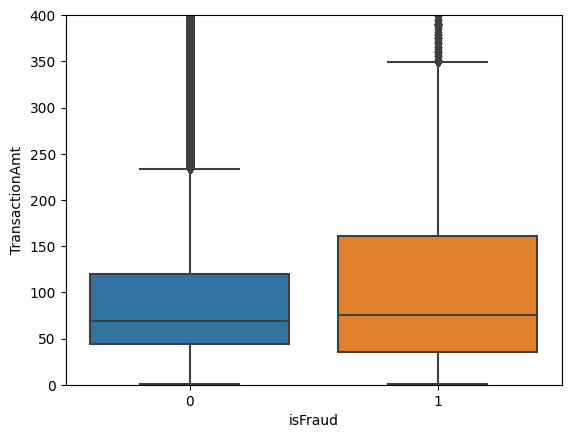

In [4]:
sns.boxplot(data=train_transaction, x='isFraud', y='TransactionAmt').axis(ymin=0,ymax=400)

### Takeaways - Transaction Amount

The distribution of fraudulent transactions appear to be somewhat greater than for the transactions not marked as fraud. This feature should be included in the model. 

## Look at an Example of Fraud

In [5]:
tmp_fraud_id = train_transaction[train_transaction['isFraud'] == 1].TransactionID.sample(1).values[0]
train_transaction[
    train_transaction['TransactionID'] == tmp_fraud_id
    ]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
295081,3282081,1,7291745,26.706,C,9917,142.0,185.0,visa,138.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train_identity[train_identity['TransactionID'] == tmp_fraud_id]

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
88124,3282081,-10.0,774941.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 64.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F5121 Build/34.3.A.0.252


# III. Training a Model

## Baseline Model with KNN

*NOTE - Naikaj you may want to code the normalization code here in a separate cell and I can insert it into the long method chaining I do in the following cell*

In [7]:
# Split the data into training and test sets

tmp = (
    # One-hot encode the desired variables, leaving one value out as default
    pd.get_dummies(train_transaction, columns=['ProductCD', 'card4', 'card6'], prefix=['ProductCD', 'card4', 'card6'])

    # Join 2 columns of identity data and then create a new variable to indicate match between tables
    .merge(train_identity.iloc[:,range(2)], on='TransactionID', how='left')
    .assign(have_identity=lambda df: ~pd.isna(df['id_01']))

    # Drop every column not listed
    .loc[:,['isFraud', 'TransactionDT', 'TransactionAmt', 'card4_discover', 'card4_mastercard', 'card4_visa',
            'ProductCD_H', 'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card6_charge card', 'card6_credit', 'card6_debit', 'card6_debit or credit',
            'C1', 'C2', 'C3', 'C4', 'C5', 'have_identity']]
    )

# Split data into test and training set using scikit-learn method
X_train, X_test, y_train, y_test = train_test_split(tmp.loc[:, tmp.columns != 'isFraud'], tmp['isFraud'], random_state=1)

del tmp

# Now we need to downsample the training set to include an even amount of fraud and non-fraud transactions
## Start by rejoining the X and Y variables into one DataFrame
tmp = X_train
tmp['isFraud'] = y_train

## Use groupby and sample to perform stratified random sample on isFraud
tmp = tmp.groupby('isFraud').sample(12500)

## Split the data back into two datasets - note that we dropped a lot of rows in the last step
y_train = tmp['isFraud']
X_train = tmp.loc[:, tmp.columns != 'isFraud']

del tmp

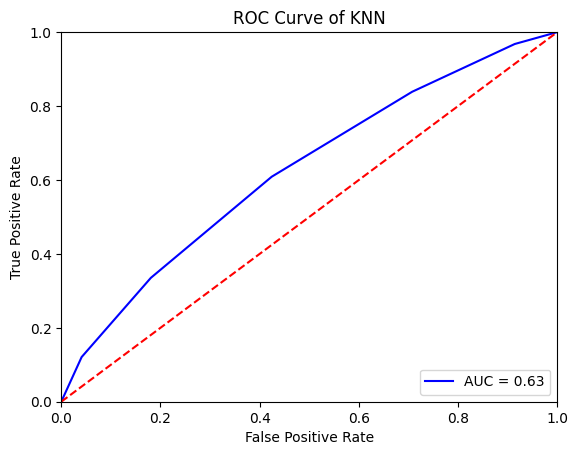

In [8]:
knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(X_train, y_train)

y_scores = knn.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Baseline KNN Model')
plt.show()